In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy
import astropy.units as u
import astropy.constants as ac
import sunpy.map
import sunpy.visualization.colormaps as cm
import skimage
import glob

from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

import random

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers


import autoenc_model as aem
import data_generator as dg
import utils
import json

import umap

from mpl_toolkits.mplot3d import Axes3D

import ipywidgets as widgets
import open3d as o3d

import datetime
from tqdm.notebook import tqdm


/home/eugeniolr/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/eugeniolr/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/eugeniolr/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWa

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
latent_size = 1024
batch_size = 48
all_gen_input = dg.MultiChannelAEGenerator("data/composite_data/", batch_size, test_split=0, shuffle=False, noise_filter=False)
all_gen_input.take_all = True

In [3]:
weights = tf.constant([0.5,0.5,2])
def modified_mse(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(tf.reduce_mean(squared_difference, axis=(0,1,2)) * weights) # Note the `axis=-1`

autoencoder = keras.models.load_model("autoencoder_VAE_ft_1024_xception.h5", custom_objects={"modified_mse": modified_mse})
encoder = keras.models.load_model("encoder_VAE_ft_1024_xception.h5")
decoder = keras.models.load_model("decoder_VAE_ft_1024_xception.h5")

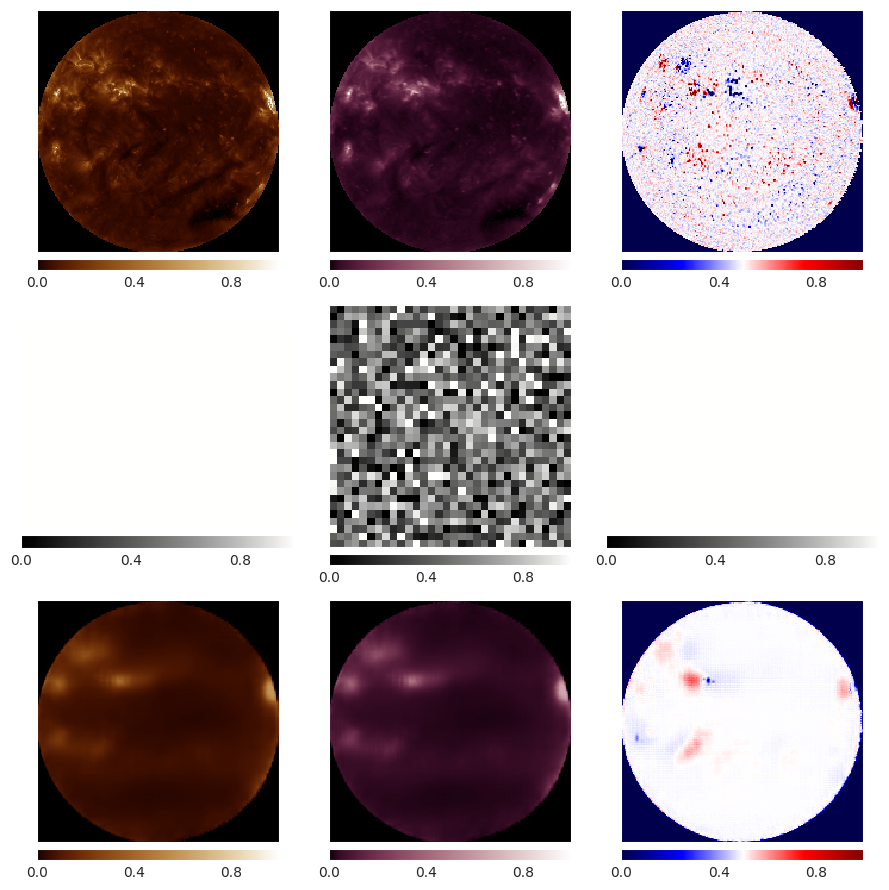

In [10]:
test_img = all_gen_input.sample(1)
#code = encoder(test_img)
mean, var, code = encoder(test_img)
decoded = decoder(code)

test_img_channels = [i for i in test_img[0].transpose(2,0,1)]


code = (utils.square_dims_vector(np.asarray(code[0])) + 1)/2
code_img = [np.ones((3,4)), code, np.ones((3,4))]
                     
decoded_img_channels = [i for i in np.asarray(decoded[0]).transpose(2,0,1)]

isns.ImageGrid(
    test_img_channels+code_img+decoded_img_channels,
    cmap=["sdoaia193", "sdoaia211", "seismic"] + ["gray"]*3 + ["sdoaia193", "sdoaia211", "seismic"],
    orientation="h",
    vmin=0, 
    vmax=1
)

In [11]:
latent_size = 1024
codes = np.empty((len(all_gen_input.file_list), latent_size))
for idx, val in tqdm(enumerate(all_gen_input), total=len(all_gen_input), desc="Encoding images"):
    codes[batch_size*idx:batch_size*(idx+1)] = encoder.predict(val[0], verbose=False)[2]

Encoding images:   0%|          | 0/534 [00:00<?, ?it/s]

In [12]:
codes.shape

(25650, 1024)

In [58]:
gmm_model = GaussianMixture(n_components = 80, covariance_type="full")
# gmm_model = BayesianGaussianMixture(n_components = 20, covariance_type="full")
gmm_model = gmm_model.fit(codes)

(80, 1024)


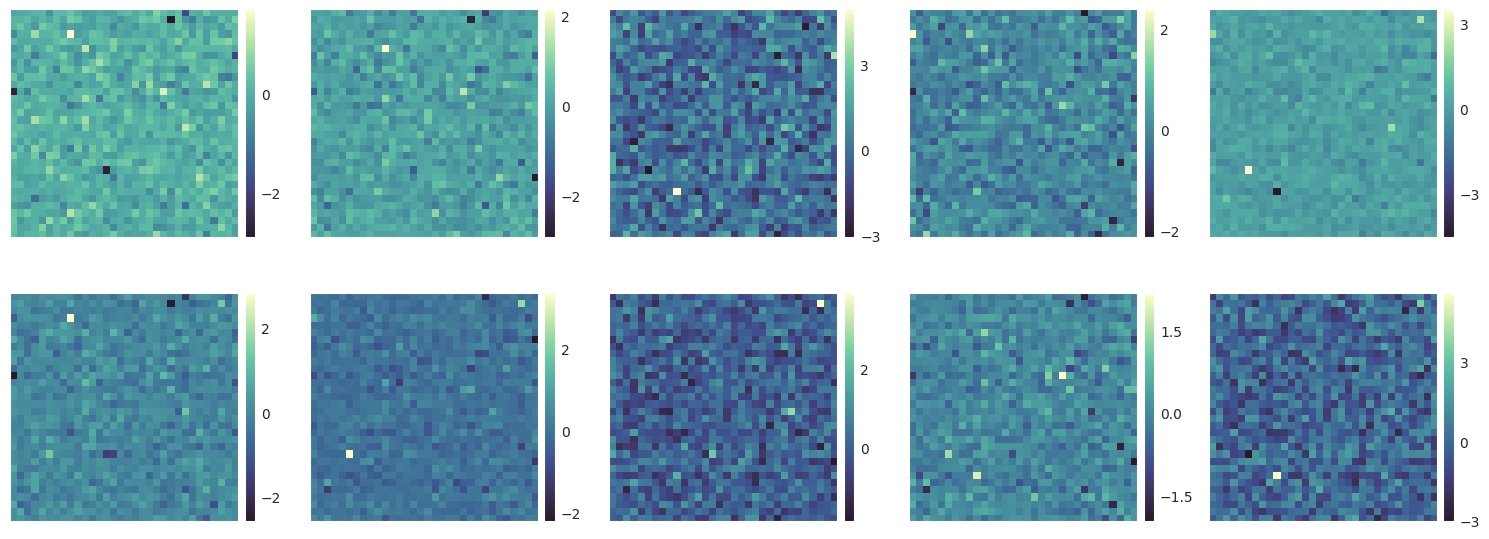

In [61]:
print(gmm_model.means_.shape)
isns.ImageGrid(gmm_model.means_.reshape([-1, 32, 32])[:10].transpose(1,2,0), col_wrap=5, cmap="deep")

(80, 204, 204, 3)


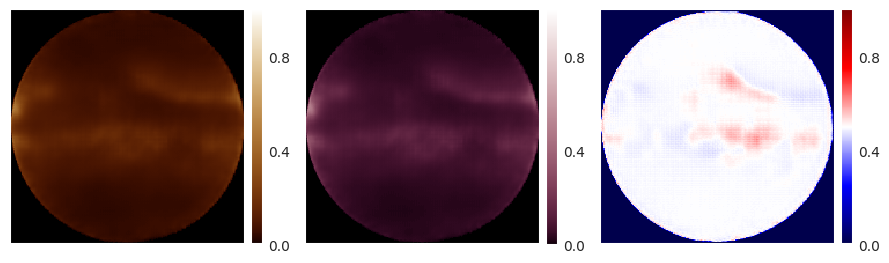

In [63]:
mean_images = np.asarray(decoder(gmm_model.means_))
print(mean_images.shape)
#isns.ImageGrid(mean_images, col_wrap=5)
isns.rgbplot(mean_images[79], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)

In [16]:
# gmm_model.aic(codes)

In [64]:
code_samples = gmm_model.sample(24)
print(code_samples[1])

[ 2  4  6  6  6  8 27 27 28 35 36 38 39 46 52 52 54 57 57 62 64 67 69 79]


In [65]:
sample_images = np.asarray(decoder(code_samples[0]))

In [71]:
c = 0

sample nº23


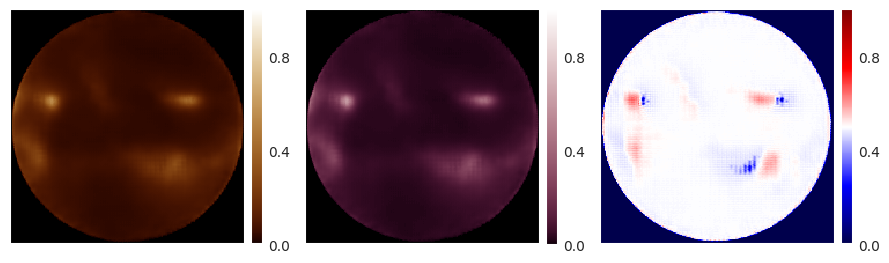

In [94]:
c = (c+1)%24
print(f"sample nº{c+1}")
isns.rgbplot(sample_images[c], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)

In [54]:
aic_values = []
for i in range(1, 200):
    print(f"Start {i}", end=" - ")
    gmm_model = GaussianMixture(n_components = i, covariance_type="full")
    gmm_model = gmm_model.fit(codes)

    print(f"Model Fitted", end=" - ")
    
    aic_values.append(gmm_model.aic(codes))

    print(f"Model evaluated")



Start 1 - Model Fitted - Model evaluated
Start 2 - Model Fitted - Model evaluated
Start 3 - Model Fitted - Model evaluated
Start 4 - Model Fitted - Model evaluated
Start 5 - Model Fitted - Model evaluated
Start 6 - Model Fitted - Model evaluated
Start 7 - Model Fitted - Model evaluated
Start 8 - Model Fitted - Model evaluated
Start 9 - Model Fitted - Model evaluated
Start 10 - Model Fitted - Model evaluated
Start 11 - Model Fitted - Model evaluated
Start 12 - Model Fitted - Model evaluated
Start 13 - Model Fitted - Model evaluated
Start 14 - Model Fitted - Model evaluated
Start 15 - Model Fitted - Model evaluated
Start 16 - Model Fitted - Model evaluated
Start 17 - Model Fitted - Model evaluated
Start 18 - Model Fitted - Model evaluated
Start 19 - Model Fitted - Model evaluated
Start 20 - Model Fitted - Model evaluated
Start 21 - Model Fitted - Model evaluated
Start 22 - Model Fitted - Model evaluated
Start 23 - Model Fitted - Model evaluated
Start 24 - Model Fitted - Model evaluated
S

KeyboardInterrupt: 

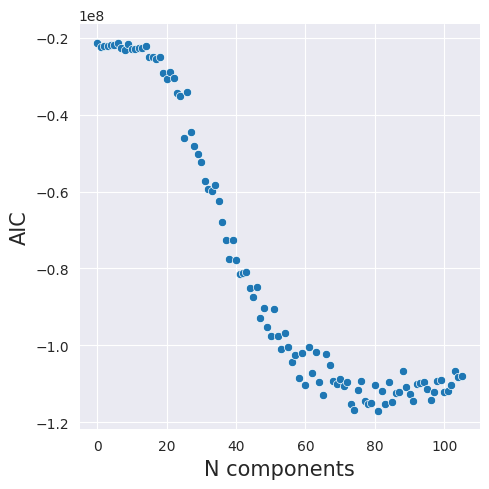

In [57]:
sns.relplot(aic_values).set(xlabel="N components", ylabel="AIC")
plt.show()